In [1]:
# from rgz_datamodules import RGZ_DataModule
from utils import Path_Handler
from rgz108k import RGZ108k 
from torch.utils.data import DataLoader
import torchvision.transforms as T

from matplotlib import pyplot as plt 

import pandas as pd

from astropy.coordinates import SkyCoord
from astropy import units as u
import pandas as pd
import numpy as np

# from astropy.io import fits
from astroquery.skyview import SkyView
from astropy.coordinates import SkyCoord
from astropy import units as u


import numpy as np
import pandas as pd
from PIL import Image
import torchvision.transforms as T


In [2]:
device =  'cpu' #torch.device('cuda' if torch.cuda.is_available() else 'cpu')

paths = Path_Handler()._dict()

transform = T.Compose(
    [
        T.CenterCrop(70),
        T.ToTensor(),
        T.Normalize((0.008008896,), (0.05303395,)),
    ]
)


In [3]:
# Load in RGZ dataset; make sure path is correctly specified
# Specify angular size cutoff in arcseconds and mirabest cut
# paths["rgz"] = '/home/k22562dm/code/rgzeval/data'

train_dataset = RGZ108k(paths["rgz"], train=True, transform=transform, cut_threshold= 20, mb_cut=True)
test_dataset = RGZ108k(paths["rgz"], train=False, transform=transform, cut_threshold= 20, mb_cut=True)

Removing duplicates from RGZ dataset...
Removed 7231 duplicate samples
Removing 28504 samples below angular size threshold.
Removed 1250 MiraBest samples from RGZ
(69015, 150, 150, 1)
Removing duplicates from RGZ dataset...
Removed 149 duplicate samples
Removing 493 samples below angular size threshold.
Removed 27 MiraBest samples from RGZ
(1224, 150, 150, 1)


In [4]:
# create data loaders 
batch_size = 1024
train_loader = DataLoader(train_dataset, batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size, shuffle=True)

In [5]:
# function to visualise samples for a given interval mean
def visualize_samples_by_interval(dataloader, dataframe, choice, interval, num_samples=5, images_per_row=5):
    """
    Visualize samples from the dataset based on specified intervals.

    Parameters:
        dataloader: The DataLoader object containing the training dataset.
        dataframe (DataFrame): A pandas DataFrame containing metadata and additional information for visualization.
        choice (str): Specifies the type of interval to use for visualization. 
                    Options are:
                    - 'Interval mean': Visualizes intervals based on the mean of energy score.
                    - 'Interval std': Visualizes intervals based on the standard deviation of energy score.
        interval (int): The interval index to use for visualization. 
                        For 'Interval mean', valid values are integers between 1 and 8 (inclusive).
                        For 'Interval std', valid values are integers between 1 and 6 (inclusive).
        num_samples (int): The number of samples to visualize.
        images_per_row (int): The number of images to display per row in the visualization.

    Returns:
        None: This function does not return a value. It displays the visualized samples.
    """
    # Filter the dataframe for the specified interval mean
    filtered_df = dataframe[dataframe[choice] == interval]
    # Get the IDs
    rgz_ids = filtered_df['id'].tolist()  
    
    # Initialize the plot
    # fig, axes = plt.subplots(1, num_samples, figsize=(15, 5))
    rows = (num_samples + images_per_row - 1) // images_per_row  # Calculate the number of rows needed
    fig, axes = plt.subplots(rows, images_per_row, figsize=(images_per_row * 3, rows * 3), dpi = 200)
    axes = axes.flatten()  # Flatten the axes for easier indexing
    
    sample_count = 0


    # Iterate through the dataloader
    for x_batch, y_batch in dataloader:
        for i in range(len(y_batch['id'])):
            if y_batch['id'][i] in rgz_ids:
                # Visualize the sample
                image = x_batch[i].squeeze().cpu().numpy()
                axes[sample_count].imshow(image, cmap='hot')
                axes[sample_count].set_title(f"ID: {y_batch['id'][i]}")
                axes[sample_count].axis('off')
                sample_count += 1

                # Stop once we have enough samples
                if sample_count == num_samples:
                    break
        if sample_count == num_samples:
            break
    # Hide unused axes
    for k in range(sample_count, len(axes)):
        axes[k].axis('off')

    plt.tight_layout()
    plt.show()


In [6]:
#load in the dataframe
df = pd.read_csv('hmc_rgz_deduplicated.csv')
#apply angular size cut to the csv (in arcseconds)
df20 = df[df['las'] > 20]


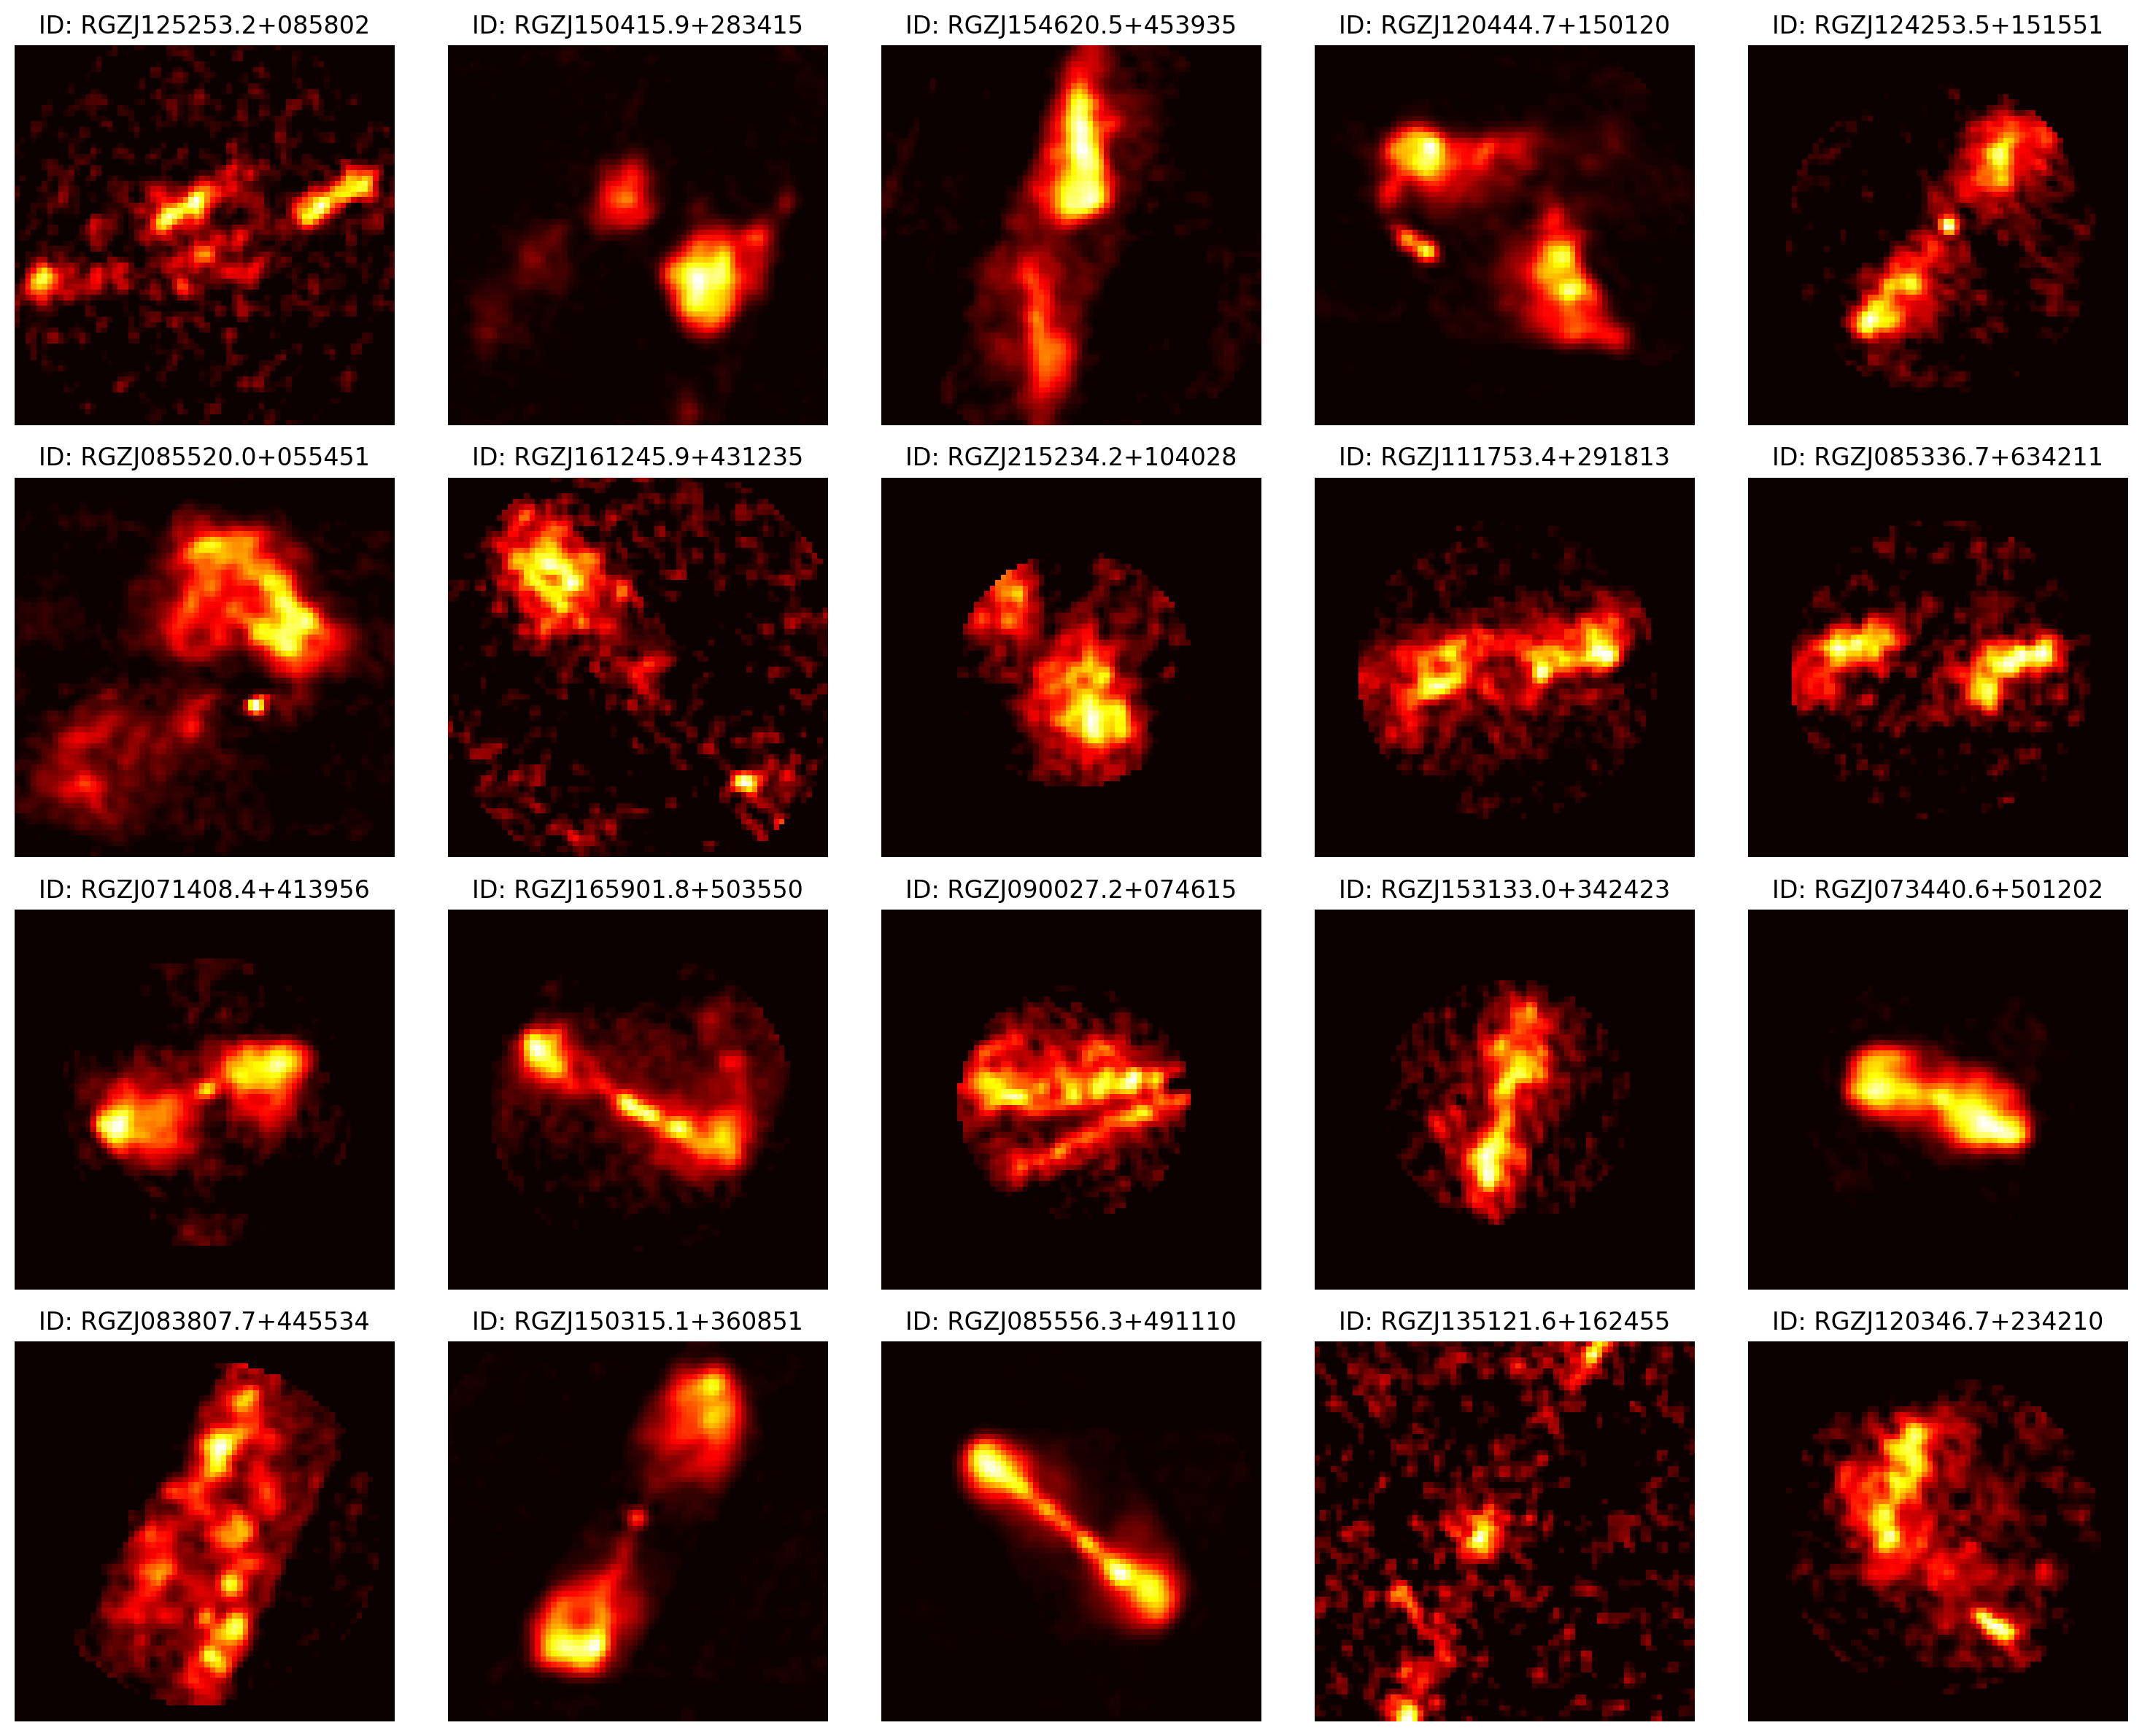

In [7]:
visualize_samples_by_interval(train_loader, df20, choice = 'Interval std', interval=6, num_samples=20, images_per_row=5)

In [8]:
# example to see the dataframe columns that match a specific interval mean, sorted by interval std
df20[df20['Interval mean'] == 8].sort_values(by='Interval std', ascending=False)

,id,las,HMC RGZ,HMC RGZ std,Interval mean,Interval std,pred entropy,mutual info,radio.ra,radio.dec
34979,RGZJ134533.5+621107,116.102440,-9.735017,18.692194,8,6,0.682214,0.283763,206.389750,62.185301
6475,RGZJ162727.1+143627,97.002620,-9.560647,13.499609,8,5,0.658766,0.243382,246.862929,14.607772
40885,RGZJ170141.6+235741,118.544439,-10.585210,14.505547,8,5,0.675830,0.305144,255.423459,23.961507
57662,RGZJ161130.0+325826,117.864039,-9.758459,13.516835,8,5,0.688894,0.281781,242.875094,32.974165
86243,RGZJ105848.3+252342,93.442486,-9.487388,13.383630,8,5,0.645105,0.302263,164.721999,25.395623
93716,RGZJ161750.9+345556,104.671914,-8.429235,14.364888,8,5,0.655682,0.268499,244.461933,34.932343
79989,RGZJ110729.8+210600,30.134005,-9.496113,10.663819,8,4,0.664316,0.377398,166.874625,21.099846
85960,RGZJ135546.8+253423,129.424855,-9.248268,11.257689,8,4,0.691449,0.371564,208.944933,25.573094
324,RGZJ102832.0+231231,24.820409,-8.491942,9.776582,8,3,0.692238,0.206926,157.131873,23.207313


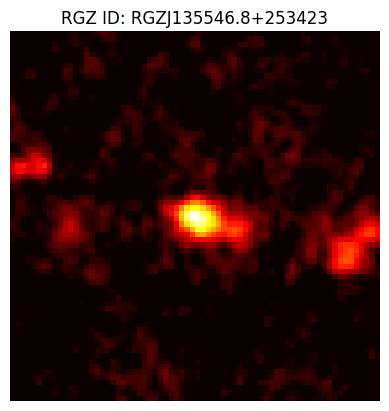

In [9]:
def get_rgz_image(rgz_id, dataset):
    # Iterate through the dataset to find the image corresponding to the RGZ ID
    for x_batch, y_batch in DataLoader(dataset, batch_size=1, shuffle=False):
        if y_batch['id'][0] == rgz_id:
            # Extract the image
            image = x_batch[0].squeeze().cpu().numpy()
            return image
    print(f"No image found for RGZ ID: {rgz_id}")
    return None

def view_rgz_image_by_id(rgz_id, dataset):
    # Retrieve and display the image
    img = get_rgz_image(rgz_id, dataset)
    if img is not None:
        plt.imshow(img, cmap='hot')
        plt.title(f"RGZ ID: {rgz_id}")
        plt.axis('off')
        plt.show()

# Example usage
view_rgz_image_by_id('RGZJ135546.8+253423', train_dataset)